In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import funcs as f
from itertools import combinations 

import vtreat
import vtreat.util

from os import path as op

import gc

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import minmax_scale
import category_encoders as ce
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, accuracy_score, precision_score, recall_score


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier, VotingClassifier, RandomTreesEmbedding
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier, SGDClassifier, LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING

import xgboost as xgb
from xgboost import XGBClassifier
import xgbfir

import KTBoost.KTBoost as KTBoost

import warnings
warnings.filterwarnings("ignore")

rand_state = 42

//anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [3]:
data = pd.read_csv('student-data.csv')
#rename passed as target
data.rename(columns={"passed": "target"}, inplace = True)
#relabel target to find failing students no:1 yes :0
data['target'] = data['target'].map({'no':0, 'yes':1})


In [4]:
#organize and catgorize variables
nom_cols = 'Mjob Fjob reason guardian'.split()
bin_cols = 'school sex address famsize Pstatus schoolsup famsup paid activities nursery higher internet romantic'.split()
ord_cols = 'Medu Fedu traveltime studytime failures famrel freetime goout Dalc Walc health'.split()
other = 'age absences'.split()
used_cols = nom_cols+bin_cols+ord_cols+other
# for col in ord_cols:
#     print(data[col].value_counts())

## Feature Cleaning / Engineering
### Binary encoding 

In [5]:
#catgorical mappings and yes/no go through a loop
data['schoolE'] = data['school'].map({'GP':0, 'MS':1})
data['sexE'] = data['sex'].map({'F':1, 'M':0})
data['addressE'] = data['address'].map({'U':0, 'R':1})
data['famsizeE'] = data['famsize'].map({'GT3':1, 'LE3':0})
data['PstatusE'] = data['Pstatus'].map({'A':0, 'T':1})
for col in 'activities nursery higher internet romantic famsup schoolsup paid'.split():
    encoded = col + 'E'
    data[encoded] = data[col].map({'no':0, 'yes':1})


### Target Encode Nominal Variables

In [227]:
for col in nom_cols:
    encoded = col+ 'E'
    data[encoded] = data[col].map(data.groupby(col)['target'].mean())

### No encoding for the ordinals for now 

### Engineering a Ratio Feature from Study Time, Freetime & GoOut, Freetime 

In [231]:
data['ratio_st_ft'] = data['studytime'] / data['freetime']
data['ratio_go_ft'] = data['goout'] / data['freetime']

### Lets average the parents education based on the reported guardian
* favor the guardian eduation .6 weight
* if guardian other then evenly find the average

In [233]:
data['Mweights'] = data['guardian'].map({'mother': .6, 'father': .4, 'other':.5})
data['Fweights'] = data['guardian'].map({'mother': .4, 'father': .6, 'other':.5})
data['Pedu'] = (data['Mweights']*data['Medu'])+(data['Fweights']*data['Fedu'])

### Create a tuple variable of SchoolSup and Paid

In [244]:
data['spsup'] = list(zip(data['schoolsupE'], data['paidE']))

### Observation:
* The level of target in each support combination changes so it may be a good feature to include 
* It will be target encoded

In [245]:
data['spfsup'] = list(zip(data['schoolsupE'], data['paidE'], data['famsupE']))
data['spfsup'] = data['spfsup'].map({(0,0,0): 'no_sup', (1,0,0): 'sch',(0,1,0): 'paid',(0,0,1): 'fam',
                                     (1,1,0):'sch_paid',(1,0,1):'sch_fam', (0,1,1):'paid_fam',
                                     (1,1,1): 'all'})
data['spfsupE'] = data['spfsup'].map(data.groupby('spfsup')['target'].mean())

### Bin Absences

In [251]:
data['absences_binned'] = data['absences'].apply(f.abs_bin)

In [253]:
feat_eng_1 = data[['school','age',
 'sex',
 'address',
 'famsize',
 'Pstatus',
 'Mjob',
 'Fjob',
 'reason',
 'traveltime',
 'failures',
 'activities',
 'nursery',
 'higher',
 'internet',
 'romantic',
 'famrel',
 'goout',
 'Dalc',
 'Walc',
 'health',
 'absences_binned',
 'ratio_st_ft',
 'Pedu',
 'spsup', 'target']]

In [254]:
feat_eng_1.to_csv('feat_eng_1.csv')

# Okay we are ready to throw it into models

## All 30 original feature thrown through vtreat and into a classificaiton pipeline 

In [255]:
baseline_feats = used_cols
X = data[baseline_feats]
y = data['target']



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = rand_state, stratify = y)

transform = vtreat.BinomialOutcomeTreatment(
    outcome_name='target',    # outcome variable
    outcome_target=1,  # outcome of interest
)

X_train_prep = transform.fit_transform(X_train, y_train)
X_train_prep_use = X_train_prep[transform.score_frame_.variable[transform.score_frame_.recommended == True].tolist()]
X_train_prep_use.columns.to_list()


['failures',
 'goout',
 'higher_logit_code',
 'higher_prevalence_code',
 'higher_lev_yes']

LogReg: 0.733606 (+/- 0.095494)
XGBClassifier: 0.689638 (+/- 0.122390)
DecisionTreeClassifier: 0.616769 (+/- 0.109333)
RandomForestClassifier: 0.679594 (+/- 0.101891)
GradientBoostingClassifier: 0.678079 (+/- 0.139164)
RidgeClassifier: 0.728755 (+/- 0.103270)
BaggingClassifier: 0.652861 (+/- 0.126262)
ExtraTreesClassifier: 0.646224 (+/- 0.077915)
Support Vector Machines: 0.687354 (+/- 0.117716)
GaussianNB: 0.737901 (+/- 0.076007)


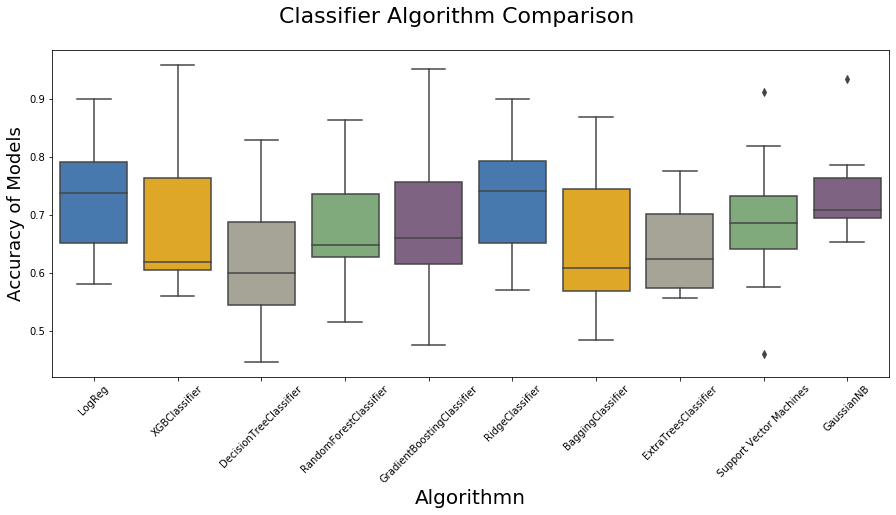

In [256]:
f.clf(X_train_prep_use.values, y_train, scoring = 'roc_auc')

## Observations:
* Logistic Rgression and GaussianNB perform the best with this Vtreat-ed data

### Analyzing Testing data using LogisticRegression

In [261]:
X_test_prep = transform.transform(X_test)
X_test_prep_use = X_test_prep[transform.score_frame_.variable[transform.score_frame_.recommended == True].tolist()]

scaler = StandardScaler()
X_train_prep_use_scaled = scaler.fit_transform(X_train_prep_use)
X_test_prep_use_scaled = scaler.fit_transform(X_test_prep_use)

lr = LogisticRegressionCV(cv=10, class_weight='balanced', n_jobs=-1, max_iter = 250)
lr.fit(X_train_prep_use_scaled, y_train)
y_train_pred = lr.predict_proba(X_train_prep_use_scaled)[:,1]


y_test_pred = lr.predict_proba(X_test_prep_use_scaled)[:,1]

print("Training Accuracy:", lr.score(X_train_prep_use_scaled, y_train))
print("Training AUC", roc_auc_score(y_train, y_train_pred))
print("Training F1", f1_score(y_train, y_train_pred > 0.5))
print("Confusion Matrix:")
print(confusion_matrix(y_train, y_train_pred > 0.5))
print("-" * 40)
print("Test Accuracy:", lr.score(X_test_prep_use_scaled, y_test))
print("Test AUC", roc_auc_score(y_test, y_test_pred))
print("Test F1", f1_score(y_test, y_test_pred > 0.5))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred > 0.5))
print()

Training Accuracy: 0.7463768115942029
Training AUC 0.7381942381942381
Training F1 0.8275862068965517
Confusion Matrix:
[[ 38  53]
 [ 17 168]]
----------------------------------------
Test Accuracy: 0.6554621848739496
Test AUC 0.6161858974358975
Test F1 0.7573964497041421
Confusion Matrix:
[[14 25]
 [16 64]]



### Observation: 
* The LogisticRegression Model when used on Test data is overfitting 0.73 -> 0.61
* Looking at the confusion matrices also shows undesierable results with too many false positives and negatives

## Feature engineered and then put through Vtreat

In [40]:
df = pd.read_csv('data_eng.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df['passed'] = df['passed'].map({'no': 0, 'yes': 1})
X = df.drop(columns=['passed'])
y = df['passed']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = rand_state, stratify = y)

transform = vtreat.BinomialOutcomeTreatment(
    outcome_name='target',    # outcome variable
    outcome_target=1,  # outcome of interest
)

X_train_prep = transform.fit_transform(X_train, y_train)
X_train_prep_use = X_train_prep[transform.score_frame_.variable[transform.score_frame_.recommended == True].tolist()]
X_train_prep_use.columns.to_list()

['failures',
 'goout',
 'higher_logit_code',
 'higher_prevalence_code',
 'higher_lev_yes']

LogReg: 0.730347 (+/- 0.096763)
XGBClassifier: 0.719558 (+/- 0.116819)
DecisionTreeClassifier: 0.647858 (+/- 0.117345)
RandomForestClassifier: 0.660971 (+/- 0.146107)
GradientBoostingClassifier: 0.663200 (+/- 0.167598)
RidgeClassifier: 0.733329 (+/- 0.095956)
BaggingClassifier: 0.669743 (+/- 0.125936)
ExtraTreesClassifier: 0.662172 (+/- 0.147505)
Support Vector Machines: 0.709679 (+/- 0.099618)
GaussianNB: 0.737023 (+/- 0.081175)


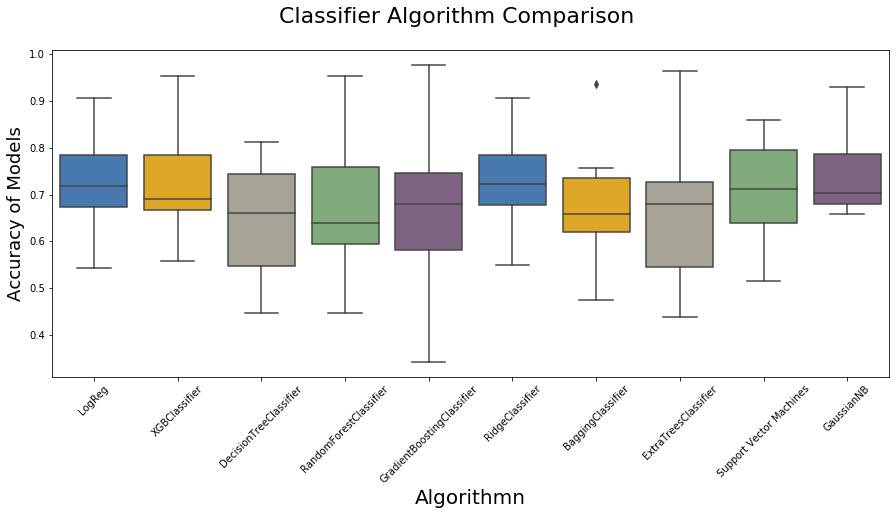

In [41]:
f.clf(X_train_prep_use.values, y_train, scoring = 'roc_auc')

## Observation:
* Feature Engineering and VTreat improvd the other models so they ar performing on level with LogisticRegression and GaussianNB now
* Some models have much more variability possibly due to size of data - GradientBoostingClassifier, ExtraTresCLassifier


## Included age in features from above and thrown though vtreat

In [42]:

df2 = pd.read_csv('feat_eng_1.csv')
df2.drop(columns = ['Unnamed: 0'], inplace = True)
X = df2.drop(columns=['target'])
y = df2['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = rand_state, stratify = y)

transform = vtreat.BinomialOutcomeTreatment(
    outcome_name='target',    # outcome variable
    outcome_target=1,  # outcome of interest
)

X_train_prep = transform.fit_transform(X_train, y_train)
X_train_prep_use = X_train_prep[transform.score_frame_.variable[transform.score_frame_.recommended == True].tolist()]
X_train_prep_use.columns.to_list()

['failures', 'goout', 'higher_prevalence_code', 'higher_lev_yes']

LogReg: 0.732829 (+/- 0.086123)
XGBClassifier: 0.705216 (+/- 0.094378)
DecisionTreeClassifier: 0.694694 (+/- 0.129845)
RandomForestClassifier: 0.696060 (+/- 0.117804)
GradientBoostingClassifier: 0.681084 (+/- 0.140253)
RidgeClassifier: 0.730074 (+/- 0.090743)
BaggingClassifier: 0.698371 (+/- 0.119208)
ExtraTreesClassifier: 0.690067 (+/- 0.130629)
Support Vector Machines: 0.652905 (+/- 0.103508)
GaussianNB: 0.740729 (+/- 0.078724)


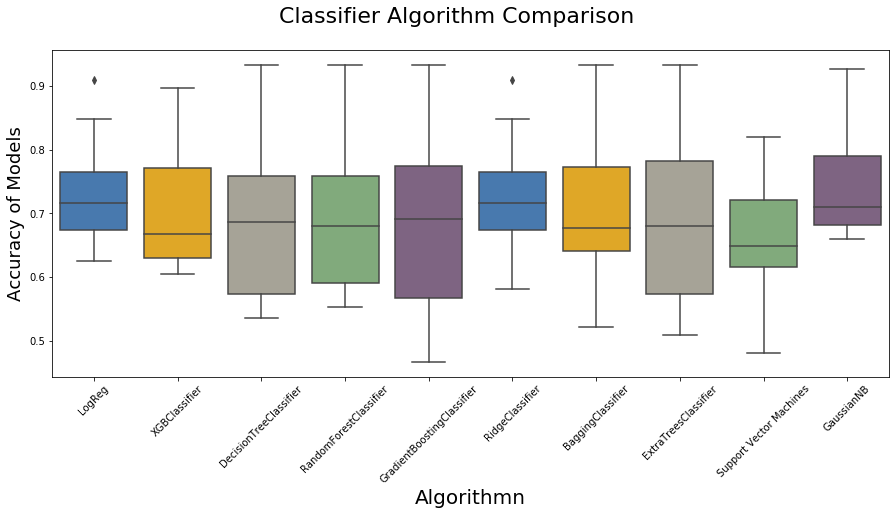

In [43]:
f.clf(X_train_prep_use.values, y_train, scoring = 'roc_auc')

### Observation:
* Logistic Regression is still among the highest prforming and so sems stable

In [44]:
X_test_prep = transform.transform(X_test)
X_test_prep_use = X_test_prep[transform.score_frame_.variable[transform.score_frame_.recommended == True].tolist()]

In [45]:
X_test_prep = transform.transform(X_test)
X_test_prep_use = X_test_prep[transform.score_frame_.variable[transform.score_frame_.recommended == True].tolist()]

scaler = StandardScaler()
X_train_prep_use_scaled = scaler.fit_transform(X_train_prep_use)
X_test_prep_use_scaled = scaler.fit_transform(X_test_prep_use)

lr = LogisticRegressionCV(cv=10, class_weight='balanced', n_jobs=-1, max_iter = 250)
lr.fit(X_train_prep_use_scaled, y_train)
y_train_pred = lr.predict_proba(X_train_prep_use_scaled)[:,1]


y_test_pred = lr.predict_proba(X_test_prep_use_scaled)[:,1]

print("Training Accuracy:", lr.score(X_train_prep_use_scaled, y_train))
print("Training AUC", roc_auc_score(y_train, y_train_pred))
print("Training F1", f1_score(y_train, y_train_pred > 0.5))
print("Confusion Matrix:")
print(confusion_matrix(y_train, y_train_pred > 0.5))
print("-" * 40)
print("Test Accuracy:", lr.score(X_test_prep_use_scaled, y_test))
print("Test AUC", roc_auc_score(y_test, y_test_pred))
print("Test F1", f1_score(y_test, y_test_pred > 0.5))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred > 0.5))
print()

Training Accuracy: 0.7463768115942029
Training AUC 0.7405999405999406
Training F1 0.8275862068965517
Confusion Matrix:
[[ 38  53]
 [ 17 168]]
----------------------------------------
Test Accuracy: 0.6554621848739496
Test AUC 0.6161858974358975
Test F1 0.7573964497041421
Confusion Matrix:
[[14 25]
 [16 64]]



### Observation:
* The model is still overfitting seen from the drop in score from traiing to test data 0.74 -> 0.61

## Trying KTBoost

In [39]:
model = KTBoost.BoostingClassifier(loss='deviance',base_learner='combined',
                                    update_step='newton',theta=1)
model.fit(X_train_prep_use,y_train)
y_train_pred = model.predict(X_test_prep_use)

print('Accuracy Score : ' + str(accuracy_score(y_test,y_train_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_train_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_train_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_train_pred)))
print("AUC", roc_auc_score(y_test, y_train_pred))

Number of trees=37, number of kernel functions=63
Accuracy Score : 0.7058823529411765
Precision Score : 0.7102803738317757
Recall Score : 0.95
F1 Score : 0.8128342245989305
AUC 0.5775641025641025


### Observation: 
* KTBoost is did not prive to be very sucessful model for this data with an AUC just over a coin flip at 0.57

## What If I don't use Vtreat?

In [103]:
data['spsupE'] = data['spsup'].map(data.groupby('spsup')['target'].mean())

In [104]:
no_vtreat = data[['schoolE',
 'age',
 'sexE',
 'addressE',
 'famsizeE',
 'PstatusE',
 'MjobE',
 'FjobE',
 'reasonE',
 'traveltime',
 'failures',
 'activitiesE',
 'nurseryE',
 'higherE',
 'internetE',
 'romanticE',
 'famrel',
 'goout',
 'Dalc',
 'Walc',
 'health',
 'absences_binned',
 'ratio_st_ft',
 'Pedu',
 'spsupE', 'schoolsupE',
 'target']]

In [105]:
no_vtreat.to_csv('no_vtreat.csv')

In [36]:
X = no_vtreat.drop(columns=['target'])
y = no_vtreat['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = rand_state, stratify = y)


LogReg: 0.752296 (+/- 0.079219)
XGBClassifier: 0.772785 (+/- 0.072041)
DecisionTreeClassifier: 0.718615 (+/- 0.063917)
RandomForestClassifier: 0.731876 (+/- 0.072651)
GradientBoostingClassifier: 0.751308 (+/- 0.085433)
RidgeClassifier: 0.747209 (+/- 0.071028)
BaggingClassifier: 0.772742 (+/- 0.094107)
ExtraTreesClassifier: 0.753719 (+/- 0.084971)
Support Vector Machines: 0.724797 (+/- 0.066235)
GaussianNB: 0.742612 (+/- 0.061141)


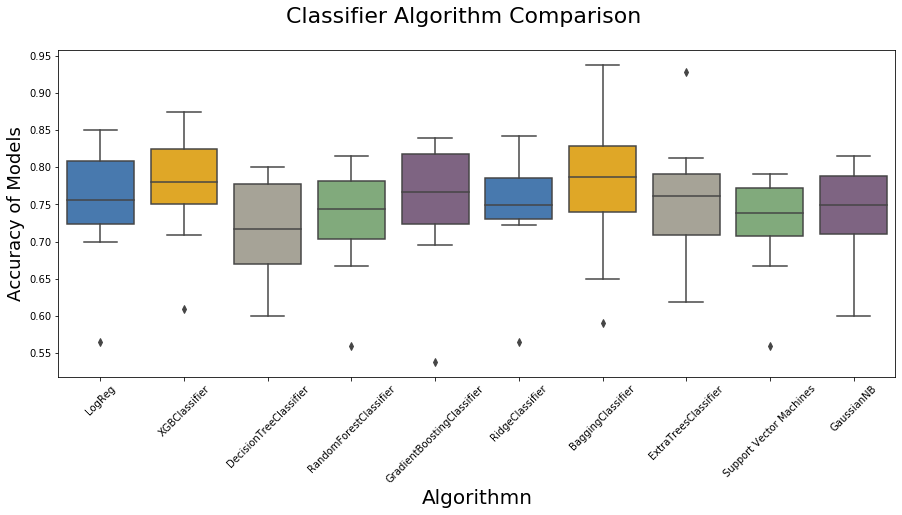

In [37]:
f.clf(X_train, y_train)

## What If I optimize LogReg ?

In [38]:
clf = LogisticRegression(class_weight='balanced')
# grid_values = {'penalty': ['l1', 'l2'],'C':[0.001,0.01,0.1,1,10,100, 1000]}
grid_values = {'penalty': ['l1', 'l2'],'C': .01*np.array(range(1,11))}
grid_clf_acc = GridSearchCV(clf, param_grid = grid_values,scoring = 'precision')
grid_clf_acc.fit(X_train_prep_use_scaled , y_train)
print(grid_clf_acc.best_params_  )
#Predict values based on new parameters

y_pred_acc = grid_clf_acc.predict(X_test_prep_use_scaled)
y_pred_prob = grid_clf_acc.predict_proba(X_test_prep_use_scaled)

# New Model Evaluation metrics 
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_acc)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_acc)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_acc)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_acc>0.5)))
print("AUC", roc_auc_score(y_test, y_pred_prob))

#Logistic Regression (Grid Search) Confusion matrix
confusion_matrix(y_test,y_pred_acc)

{'C': 0.02, 'penalty': 'l2'}
Accuracy Score : 0.6554621848739496
Precision Score : 0.7191011235955056
Recall Score : 0.8
F1 Score : 0.7573964497041421
AUC 0.5794871794871794


array([[14, 25],
       [16, 64]])

### NB 

In [39]:
nb = GaussianNB()
nb.fit(X_train_prep_use, y_train)
y_pred_acc = nb.predict(X_test_prep_use)

print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_acc)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_acc)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_acc)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_acc>0.5)))
print("AUC", roc_auc_score(y_test, y_pred_acc))

#Logistic Regression (Grid Search) Confusion matrix
confusion_matrix(y_test,y_pred_acc)

Accuracy Score : 0.6890756302521008
Precision Score : 0.7009345794392523
Recall Score : 0.9375
F1 Score : 0.8021390374331551
AUC 0.5584935897435898


array([[ 7, 32],
       [ 5, 75]])

### Bagging

In [40]:
bag = BaggingClassifier()
bag.fit(X_train_prep_use_scaled, y_train)
y_pred_acc = bag.predict(X_test_prep_use_scaled)

print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_acc)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_acc)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_acc)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_acc>0.5)))
print("AUC", roc_auc_score(y_test, y_pred_acc))

#Logistic Regression (Grid Search) Confusion matrix
confusion_matrix(y_test,y_pred_acc)

Accuracy Score : 0.680672268907563
Precision Score : 0.723404255319149
Recall Score : 0.85
F1 Score : 0.7816091954022989
AUC 0.5916666666666668


array([[13, 26],
       [12, 68]])

In [41]:
param_grid = {
    'base_estimator__max_depth' : [1, 2, 3, 4, 5],
    'max_samples' : [0.05, 0.1, 0.2, 0.5]
}

clf = GridSearchCV(BaggingClassifier(DecisionTreeClassifier(),
                                     n_estimators = 100, max_features = 0.5),
                   param_grid, scoring = 'f1')
clf.fit(X_train_prep_use_scaled, y_train)
y_pred_acc = clf.predict(X_test_prep_use_scaled)

print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_acc)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_acc)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_acc)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_acc>0.5)))
print("AUC", roc_auc_score(y_test, y_pred_acc))

#Logistic Regression (Grid Search) Confusion matrix
confusion_matrix(y_test,y_pred_acc)

Accuracy Score : 0.6890756302521008
Precision Score : 0.7128712871287128
Recall Score : 0.9
F1 Score : 0.7955801104972375
AUC 0.5782051282051281


array([[10, 29],
       [ 8, 72]])

### Ridge

In [42]:
ridge = RidgeClassifier()
ridge.fit(X_train_prep_use_scaled, y_train)
y_pred_acc = ridge.predict(X_test_prep_use_scaled)

print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_acc)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_acc)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_acc)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_acc>0.5)))
print("AUC", roc_auc_score(y_test, y_pred_acc))

#Logistic Regression (Grid Search) Confusion matrix
confusion_matrix(y_test,y_pred_acc)

Accuracy Score : 0.680672268907563
Precision Score : 0.71
Recall Score : 0.8875
F1 Score : 0.7888888888888889
AUC 0.5719551282051282


array([[10, 29],
       [ 9, 71]])

### Decision Tree

In [43]:
dt = DecisionTreeClassifier()
dt.fit(X_train_prep_use_scaled, y_train)
y_pred_acc = dt.predict(X_test_prep_use_scaled)

print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_acc)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_acc)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_acc)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_acc>0.5)))
print("AUC", roc_auc_score(y_test, y_pred_acc))

#Logistic Regression (Grid Search) Confusion matrix
confusion_matrix(y_test,y_pred_acc)

Accuracy Score : 0.680672268907563
Precision Score : 0.723404255319149
Recall Score : 0.85
F1 Score : 0.7816091954022989
AUC 0.5916666666666668


array([[13, 26],
       [12, 68]])

In [44]:

param_grid = {"criterion": ["gini", "entropy"],
              "min_samples_split": [2, 10, 20],
              "max_depth": [None, 2, 5, 10],
              "min_samples_leaf": [1, 5, 10],
              "max_leaf_nodes": [None, 5, 10, 20],
              }

clf = GridSearchCV(DecisionTreeClassifier(),
                   param_grid, scoring = 'f1')
clf.fit(X_train_prep_use_scaled, y_train)
y_pred_acc = clf.predict(X_test_prep_use_scaled)

print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_acc)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_acc)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_acc)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_acc>0.5)))
print("AUC", roc_auc_score(y_test, y_pred_acc))

#Logistic Regression (Grid Search) Confusion matrix
confusion_matrix(y_test,y_pred_acc)
print(clf.best_params_  )

Accuracy Score : 0.680672268907563
Precision Score : 0.723404255319149
Recall Score : 0.85
F1 Score : 0.7816091954022989
AUC 0.5916666666666668
{'criterion': 'gini', 'max_depth': None, 'max_leaf_nodes': None, 'min_samples_leaf': 10, 'min_samples_split': 20}


### SVM

In [45]:
svm = SVC(random_state=0, class_weight="balanced")
svm.fit(X_train, y_train)
y_pred_acc = svm.predict(X_test)

print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_acc)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_acc)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_acc)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_acc>0.5)))
print("AUC", roc_auc_score(y_test, y_pred_acc))

#Logistic Regression (Grid Search) Confusion matrix
confusion_matrix(y_test,y_pred_acc)

Accuracy Score : 0.6974789915966386
Precision Score : 0.7558139534883721
Recall Score : 0.8125
F1 Score : 0.783132530120482
AUC 0.6370192307692308


array([[18, 21],
       [15, 65]])

In [47]:
parameters = {'C':[1],'kernel':['rbf'],'degree':[1]}
svm_clf = GridSearchCV(svm, parameters, scoring = 'precision')
svm_clf.fit(X_train, y_train)
y_pred_acc = svm_clf.predict(X_test)

print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_acc)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_acc)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_acc)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_acc)))
print("AUC", roc_auc_score(y_test, y_pred_acc))
print(svm_clf.best_params_  )
#Logistic Regression (Grid Search) Confusion matrix
confusion_matrix(y_test,y_pred_acc)


Accuracy Score : 0.6974789915966386
Precision Score : 0.7558139534883721
Recall Score : 0.8125
F1 Score : 0.783132530120482
AUC 0.6370192307692308
{'C': 1, 'degree': 1, 'kernel': 'rbf'}


array([[18, 21],
       [15, 65]])

In [48]:
parameters = {'C':[.0001,.001,.01, 0.1, 1, 10],'kernel':['linear','poly','rbf','sigmoid'],'degree':range(1,6)}
svm_clf = GridSearchCV(svm, parameters, scoring = 'precision')
svm_clf.fit(X_train, y_train)
y_pred_acc = svm_clf.predict(X_test)

print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_acc)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_acc)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_acc)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_acc)))
print("AUC", roc_auc_score(y_test, y_pred_acc))
print(svm_clf.best_params_  )
#Logistic Regression (Grid Search) Confusion matrix
confusion_matrix(y_test,y_pred_acc)


Accuracy Score : 0.6050420168067226
Precision Score : 0.7323943661971831
Recall Score : 0.65
F1 Score : 0.6887417218543047
AUC 0.5814102564102563
{'C': 10, 'degree': 1, 'kernel': 'linear'}


array([[20, 19],
       [28, 52]])

### SVM scaled?

In [49]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [50]:
svm.fit(X_train_scaled, y_train)
y_pred_acc = svm.predict(X_test_scaled)

print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_acc)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_acc)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_acc)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_acc)))
print("AUC", roc_auc_score(y_test, y_pred_acc))

#Logistic Regression (Grid Search) Confusion matrix
confusion_matrix(y_test,y_pred_acc)

Accuracy Score : 0.6218487394957983
Precision Score : 0.7397260273972602
Recall Score : 0.675
F1 Score : 0.7058823529411764
AUC 0.5939102564102564


array([[20, 19],
       [26, 54]])

In [51]:
parameters = {'C':[.0001,.001,7,8.8,9,9.2, 11],'kernel':['linear','poly','rbf','sigmoid'],'degree':range(1,6),
              'gamma':[.0003,.0004,.0005]}
svm_clf = GridSearchCV(svm, parameters, scoring = 'precision')
svm_clf.fit(X_train_scaled, y_train)
y_pred_acc = svm_clf.predict(X_test_scaled)

print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_acc)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_acc)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_acc)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_acc)))
print("AUC", roc_auc_score(y_test, y_pred_acc))
print(svm_clf.best_params_  )
#Logistic Regression (Grid Search) Confusion matrix
confusion_matrix(y_test,y_pred_acc)

Accuracy Score : 0.6218487394957983
Precision Score : 0.7536231884057971
Recall Score : 0.65
F1 Score : 0.697986577181208
AUC 0.607051282051282
{'C': 7, 'degree': 1, 'gamma': 0.0003, 'kernel': 'linear'}


array([[22, 17],
       [28, 52]])

In [52]:
parameters = {'C':[.0001,.001,7,8.8,9,9.2, 11],'kernel':['linear','poly','rbf','sigmoid'],'degree':range(1,6),
              'gamma':[.00001,.0003,.0004]}
svm_clf = GridSearchCV(svm, parameters, scoring = 'precision')
svm_clf.fit(X_train, y_train)
y_pred_acc = svm_clf.predict(X_test_scaled)

print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_acc)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_acc)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_acc)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_acc)))
print("AUC", roc_auc_score(y_test, y_pred_acc))
print(svm_clf.best_params_  )
#Logistic Regression (Grid Search) Confusion matrix
confusion_matrix(y_test,y_pred_acc)

Accuracy Score : 0.5294117647058824
Precision Score : 0.8333333333333334
Recall Score : 0.375
F1 Score : 0.5172413793103448
AUC 0.6105769230769231
{'C': 9, 'degree': 1, 'gamma': 1e-05, 'kernel': 'linear'}


array([[33,  6],
       [50, 30]])

In [ ]:
parameters = {'C':[.0001,.001,7,8.8,9,9.2, 11],'kernel':['linear','poly','rbf','sigmoid'],'degree':range(1,6),
              'gamma':[.0001, .0005, .001,.01,.1,1,10]}
svm_clf = GridSearchCV(svm, parameters, scoring = 'precision')
svm_clf.fit(X_train_scaled, y_train)
y_pred_acc = svm_clf.predict(X_test_scaled)

print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_acc)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_acc)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_acc)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_acc)))
print("AUC", roc_auc_score(y_test, y_pred_acc))
print(svm_clf.best_params_  )
#Logistic Regression (Grid Search) Confusion matrix
confusion_matrix(y_test,y_pred_acc)

In [ ]:
parameters = {'C':[.0001,.001,7,8.8,9,9.2, 11],'kernel':['linear','poly','rbf','sigmoid'],'degree':range(1,6),
              'gamma':[.0003,.0004,.0005]}
svm_clf = GridSearchCV(svm, parameters, scoring = 'precision')
svm_clf.fit(X_train, y_train)
y_pred_acc = svm_clf.predict(X_test_scaled)

print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_acc)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_acc)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_acc)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_acc)))
print("AUC", roc_auc_score(y_test, y_pred_acc))
print(svm_clf.best_params_  )
#Logistic Regression (Grid Search) Confusion matrix
confusion_matrix(y_test,y_pred_acc)

## Optimization Results:
* `LogReg` 0.57
* `NB` 0.55
* `Bagging` 0.57
* `Ridge` 0.57
* `DT` 0.59
* `SVM` 0.63

None of the models are performing very well when considering ROC_AUC score. SVM scores well but is highly instable 

# Next Steps
* Split Data into two populations
* Use different fature selction methods